In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 10,65
# random_input_span = (1.2,2.8)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [7]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

# Sigma dataframe

In [8]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.167267,0.166996,0.167210,0.166446,0.168051,0.167878,0.169410,0.168822,0.169698,0.171709
0.07,0.196038,0.195933,0.197381,0.199454,0.200867,0.203007,0.211065,0.243348,0.280653,0.290554
0.09,0.208392,0.210313,0.213912,0.217833,0.220776,0.326214,0.348884,0.359419,0.364751,0.366855
0.11,0.210934,0.213694,0.217841,0.328382,0.383321,0.402497,0.409045,0.413183,0.412046,0.410863
0.13,0.220627,0.222949,0.356270,0.422891,0.440653,0.448317,0.451464,0.449346,0.449456,0.447789
0.15,0.240697,0.258516,0.448570,0.472834,0.481235,0.501248,0.505618,0.502224,0.493161,0.486336
0.17,0.229689,0.388339,0.478071,0.493453,0.497940,0.506676,0.507245,0.506065,0.505916,0.507224
0.19,0.232121,0.477131,0.518177,0.528124,0.530797,0.531293,0.532120,0.532843,0.537920,0.540845
0.21,0.251358,0.513780,0.537121,0.548599,0.551437,0.552580,0.555989,0.560244,0.569896,0.574520


Text(0.5, 1, 'Sigma as an Order parameter')

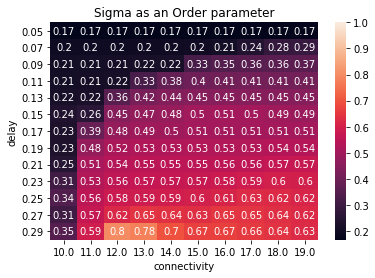

In [9]:
ax_sigma = sns.heatmap(sigma_table, annot=True, vmax = 1)
ax_sigma.set_title('Sigma as an Order parameter')

# Field period dataframe

In [10]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.980392,1.020408,1.063830,1.098901,1.142894,1.176633,1.275179,1.300676,1.021277,0.256412
0.07,1.005660,1.020408,1.081113,1.098901,1.136364,0.300272,0.303100,0.305810,0.313973,0.322581
0.09,0.980392,0.339560,0.351495,0.364300,0.354628,0.361011,0.371747,0.380954,0.390625,0.398406
0.11,0.980392,0.435831,0.396078,0.401606,0.414080,0.426441,0.438596,0.450450,0.459773,0.471698
0.13,0.471342,0.451525,0.444444,0.460829,0.476190,0.490196,0.505051,0.516799,0.531915,0.544963
0.15,0.487805,0.491403,0.502513,0.519484,0.537634,0.564972,0.579715,0.595238,0.607908,0.621118
0.17,0.509648,0.533337,0.555556,0.574713,0.595238,0.617284,0.634927,0.657895,0.680272,0.704225
0.19,0.774379,0.584795,0.609756,0.632911,0.655745,0.680272,0.704225,0.729927,0.763359,0.796825
0.21,0.607908,0.634927,0.662252,0.689655,0.714286,0.746269,0.778222,0.813008,0.858385,0.896879


Text(0.5, 1, 'Field period time')

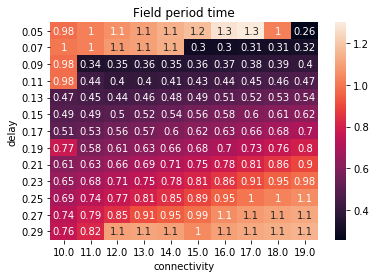

In [11]:
ax_field_period = sns.heatmap(field_period_table.abs(), annot=True)
ax_field_period.set_title('Field period time')

In [12]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,108.049961,106.053499,107.520862,106.547570,105.650720,108.215417,92.147144,88.236368,87.075885,107.911552
0.07,126.998219,118.392102,122.614270,126.190196,123.036425,139.386113,202.502451,503.376925,902.631957,803.331827
0.09,139.098757,154.155315,185.097197,203.487648,215.975838,1516.198340,1523.297127,1589.582699,1832.493992,1800.859997
0.11,148.270659,152.957973,213.003281,1159.068104,1521.192308,2064.163038,2187.968156,2301.867457,1968.860476,1890.885137
0.13,178.069553,216.053709,1442.800752,2313.033536,2247.629423,2513.207227,2567.287901,2268.522997,2199.696844,1982.860548
0.15,349.132093,429.556818,2076.616245,2213.318541,2223.253803,2339.930444,2261.913225,2376.070650,1959.796209,2294.338485
0.17,280.872957,1512.751537,2011.282040,2463.604544,2205.194866,2533.553836,2282.455974,2532.865229,2445.829667,2563.058142
0.19,274.148094,2780.512980,3112.416816,2979.417167,3114.716328,2612.984889,2902.094856,2762.159618,2987.825900,2921.995083
0.21,348.374993,2355.000139,3073.930383,3175.338699,2481.681643,2949.809453,2640.233966,2647.478680,2658.084189,2365.486876


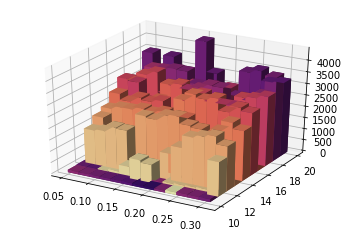

In [14]:
d_arr = max_intensity_table.index
g_arr = max_intensity_table.columns
bars_pos = np.array([np.tile(d_arr, len(g_arr)), np.repeat(g_arr, len(d_arr)),[0]*(len(d_arr)*len(g_arr))])

dd_arr = d_arr[1] - d_arr[0]
dg_arr = g_arr[1] - g_arr[0]

dmax_intensity = max_intensity_table.to_numpy().flatten()

cmap = plt.cm.get_cmap('magma_r') # Get desired colormap - you can change this!
period_arr = field_period_table.to_numpy().flatten()
max_height = np.max(period_arr)   # get range of colorbars so we can normalize
min_height = np.min(period_arr)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in period_arr] 


fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dd_arr, dg_arr, dmax_intensity, color=rgba)

# Amin Saman Parameter

In [ ]:
if neuron_model == 'Rotational':
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')